# Disparity Map Calculation

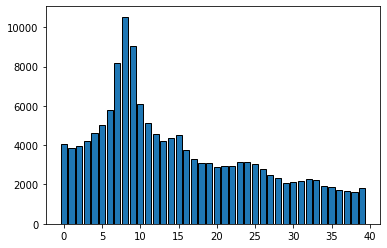

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

if __name__ == "__main__":
    XL = plt.imread('/content/im0.ppm')
    XR = plt.imread('/content/im8.ppm')

    min_diff = []
    D_map = np.zeros((381, 390), dtype=int)

    i_limit = len(XR)
    j_limit = len(XR[0]) -40
    for i in range(i_limit):
        for j in range(j_limit):
            for k in range(j, j+40, 1):
                temp1 = (XL[i][k])
                temp = XL[i][k] - XR[i][j]
                temp = abs(temp)
                temp = sum(temp)
                min_diff.append(temp)

            value = min(min_diff)
            index = min_diff.index(value)
            min_diff = []
            D_map[i][j] = index

    vector_D_Map = D_map.reshape(1, -1)

    # Saving disparity map for Question 4 
    np.savetxt('vector.txt', vector_D_Map)
    # Ploting histograms
    unique_values, frequencies = np.unique(vector_D_Map, return_counts=True)
    plt.bar(unique_values, frequencies, edgecolor='black')
    plt.show()



For the histogram I can see there are almost 4 bumbsa as shown in the figure below. Hence I assume my disparity map is composed of mixture of 4 guassian distributions. Hence, I have 4 cluster

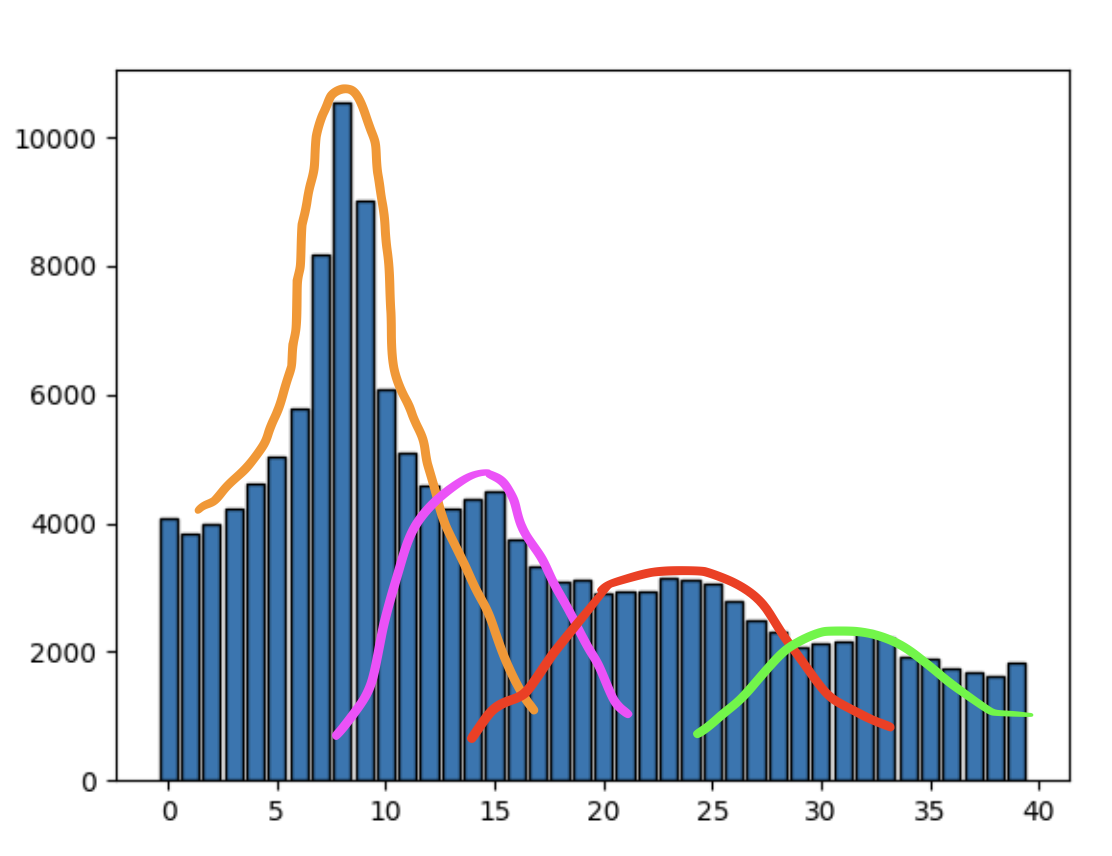

#  GMM Clustering for Enhanced Depth Map

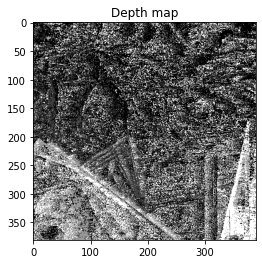

In [7]:
import numpy as np
import matplotlib.pyplot as plt

if __name__ == "__main__":

    # loading the disparity map obtained in Question 3
    vector_D_Map = np.loadtxt('vector.txt')
    # Number of cluster = 4
    k = 4
    # Mean initialization by grouping the data into 4 parts 
    # and taking the mean of each group
    groups = np.split(vector_D_Map[:148588], k)
    means = [group.mean() for group in groups]
    theta = np.array(means)
    theta = theta.reshape(-1, 1)

    theta_previous = np.zeros((4, 1))

    theta - theta_previous

    tol = 1e-5
    max_iter = 1000
    distortions = np.zeros(max_iter)

    for iteration in range(max_iter):
        # create the assignment matrix U based on the theta
        diff = (theta - vector_D_Map) ** 2
        min_indexes = np.argmin(diff, axis=0)
        U = np.zeros_like(diff)
        U[min_indexes, np.arange(U.shape[1])] = 1

        # check for convergence

        distortions[iteration] = np.sum(np.abs(theta - theta_previous))

        if iteration > 0 and np.abs(distortions[iteration] - distortions[iteration - 1]) < tol:
            break

        # update the means (theta)
        summation = np.matmul(U, vector_D_Map.reshape(-1, 1))
        num_ones = np.count_nonzero(U, axis=1)
        num_ones = num_ones.reshape(-1, 1)
        theta_previous = theta
        theta = summation / num_ones

    #generating image by replacing each element of image
    # by the mean of its cluster
    row1 = np.array([])

    for i in range(len(U[0])):
        temp = np.array(np.where(U[:, i] == 1)[0])
        row1 = np.concatenate((row1, temp))

    zero_indices = np.where(row1 == 0)
    first_indices = np.where(row1 == 1)
    second_indices = np.where(row1 == 2)
    third_indices = np.where(row1 == 3)

    D_map_new = np.zeros(148590)
    D_map_new[zero_indices] = theta[0]
    D_map_new[first_indices] = theta[1]
    D_map_new[second_indices] = theta[2]
    D_map_new[third_indices] = theta[3]

    D_map_new = D_map_new.reshape(381, 390)
    plt.imshow(D_map_new, cmap='gray')
    plt.title("Depth map")
    plt.show()


# KMeans Clustering for Depth Map Generation

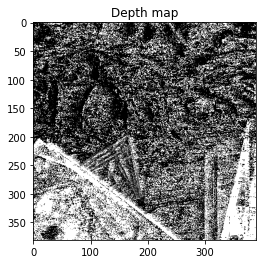

In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt


def normal_pdf(x, mu, sigma):
    pdf = 1 / (sigma * math.sqrt(2 * math.pi)) * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))
    return pdf


if __name__ == "__main__":
    
    # loading the disparity map obtained in Question 3
    X = np.loadtxt('/content/vector.txt')
    X1 = X.reshape(-1, 1)

    k = 4
    P = np.array(np.ones(k) / k)
    # Mean initialization by grouping the data into 4 parts 
    # and taking the mean of each group
    groups = np.split(X[:148588], k)
    means = [group.mean() for group in groups]
    mu = np.array(means)

    sigma = np.ones(k)

    tol = 1e-6
    max_iter = 1000
    log_likelihoods = []

    for iteration in range(max_iter):
        # E-step: compute responsibilities
        U_t = np.zeros((k, len(X)))
        for i in range(k):
            U_t[i] = normal_pdf(X, mu[i], sigma[i])
        U = np.transpose(U_t)
        P_diag = diagonal_matrix = np.diag(np.squeeze(P))
        U = U_log = np.matmul(U, P_diag)
        for j in range(len(X)):
            U[j] /= np.sum(U[j])

        # M-step: update parameters
        U_sum = np.sum(U, axis=0)
        P = U_sum / len(X)
        for k1 in range(k):
            mu[k1] = np.sum(U[:, k1]*X)/U_sum[k1]
            sigma[k1] = np.sqrt(np.sum(U[:, k1] * (X - mu[k1]) ** 2) / U_sum[k1])

        # Compute log-likelihood to check convergence 
        log_likelihood = np.sum(np.log(np.sum(U_log)))
        log_likelihoods.append(log_likelihood)

        # Check for convergence
        if iteration > 0 and np.abs(log_likelihood - log_likelihoods[-2]) < tol:
            break

    # generating image by replacing each element of image
    # by the mean of its distribution

    max_indexes = np.argmax(U, axis=1)

    zero_indices = np.where(max_indexes == 0)
    first_indices = np.where(max_indexes == 1)
    second_indices = np.where(max_indexes == 2)
    third_indices = np.where(max_indexes == 3)

    D_map_new = np.zeros(148590)
    D_map_new[zero_indices] = mu[0]
    D_map_new[first_indices] = mu[1]
    D_map_new[second_indices] = mu[2]
    D_map_new[third_indices] = mu[3]

    D_map_new = D_map_new.reshape(381, 390)
    plt.imshow(D_map_new, cmap='gray')
    plt.title("Depth map")
    plt.show()
